In [ ]:
# 1.1 Data loading and cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

if not hasattr(np, 'bool'):
    np.bool = bool

# File paths
files = [
    "./2010.4.1-2012.12.31.txt",
    "./2013-2015.txt",
    "./2015-2017.txt",
    "./2017-2019.4.29.txt"
]

# Load and merge data
dataframes = []
for file in files:
    df = pd.read_csv(file, sep="\s+", header=None, names=["Date", "Time", "Open", "Close"])
    df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
    df.drop(["Date", "Time"], axis=1, inplace=True)
    dataframes.append(df)

# Combine data
full_data = pd.concat(dataframes).sort_values("Datetime").reset_index(drop=True)
print(full_data.head())


      Open    Close            Datetime
0  3345.61  3359.57 2010-04-01 09:35:00
1  3359.83  3368.12 2010-04-01 09:40:00
2  3368.76  3371.16 2010-04-01 09:45:00
3  3370.86  3369.15 2010-04-01 09:50:00
4  3369.08  3373.68 2010-04-01 09:55:00


/var/folders/m1/vyw78ys152scdks50lb08b8h0000gn/T/ipykernel_16308/941450841.py:8: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


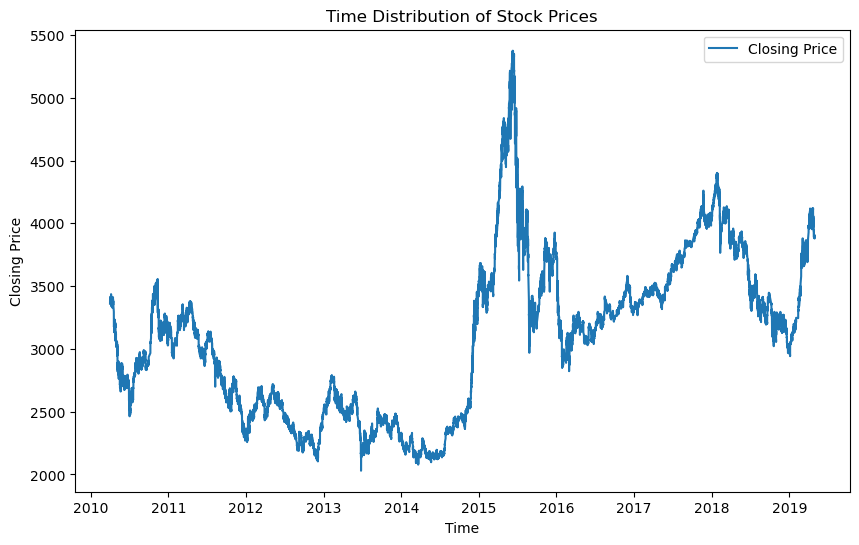

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(full_data["Datetime"], full_data["Close"], label="Closing Price")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Time Distribution of Stock Prices")
plt.legend()
plt.show()


In [ ]:
# 1.2 Data standardization and feature selection

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
full_data["Scaled_Close"] = scaler.fit_transform(full_data["Close"].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(full_data["Scaled_Close"].values, seq_length)

# Split training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [ ]:
# 1.3 Build LSTM model

In [6]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
print(model.summary())


/Users/jinhao/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# 1.4 Model training and testing

Epoch 1/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - loss: 0.0018 - val_loss: 7.0565e-04
Epoch 2/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 78s 29ms/step - loss: 2.6979e-04 - val_loss: 1.1062e-04
Epoch 3/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - loss: 2.7478e-04 - val_loss: 4.2972e-05
Epoch 4/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - loss: 2.7258e-04 - val_loss: 1.5210e-05
Epoch 5/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - loss: 2.5990e-04 - val_loss: 2.5329e-05
Epoch 6/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 2.6159e-04 - val_loss: 4.9764e-04
Epoch 7/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 2.6546e-04 - val_loss: 8.0678e-06
Epoch 8/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - loss: 2.4947e-04 - val_loss: 2.5682e-05
Epoch 9/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - loss: 2.4164e-04 - val_loss: 8.4019e-05
Epoch 10/20
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 2.4616e-04 - val_loss: 6.7935e-05
Epoch 11/20
2645/2645 ━

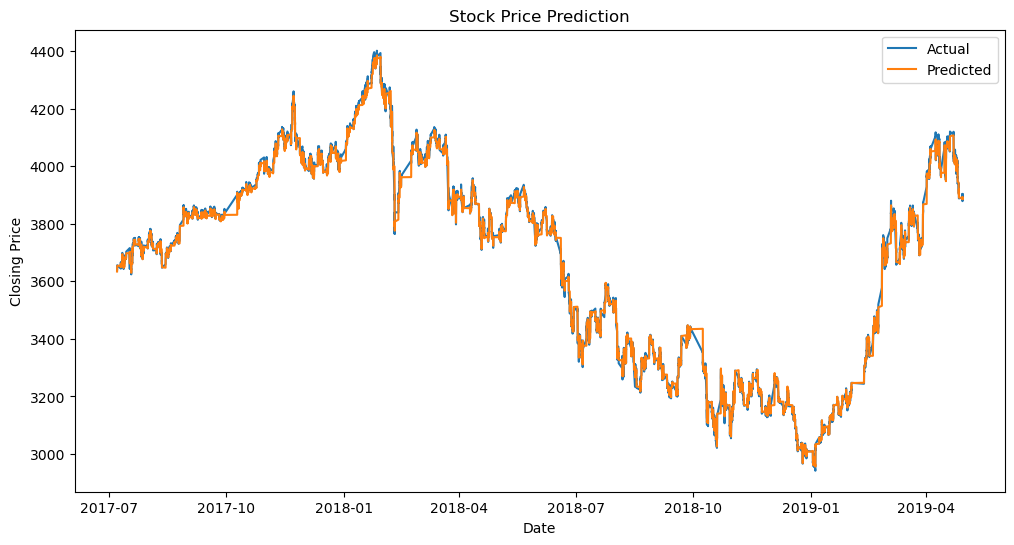

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test)
)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the results
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_scaled = scaler.inverse_transform(y_pred)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(full_data["Datetime"].iloc[-len(y_test):], y_test_scaled, label="Actual")
plt.plot(full_data["Datetime"].iloc[-len(y_test):], y_pred_scaled, label="Predicted")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Prediction")
plt.show()


In [ ]:
# 1.5 View the mean square error

In [10]:
train_mse = history.history['loss'] 
val_mse = history.history['val_loss']
print(f"Final training set MSE: {train_mse[-1]}")
print(f"Final validation set MSE: {val_mse[-1]}")

Final training set MSE: 0.00022585659462492913
Final validation set MSE: 8.116643584799021e-06
